In [1]:
import os, glob, sys, argparse
from collections import Counter

import torch
import pickle
import networkx as nx

import matplotlib.colors
import matplotlib.pyplot as plt

import numpy as np
from numpy.random import default_rng

from scipy import sparse
from scipy.sparse import coo_matrix
from scipy.spatial.distance import pdist, squareform

from gtda.plotting import plot_diagram
from gtda.graphs import GraphGeodesicDistance
from gtda.homology import VietorisRipsPersistence, SparseRipsPersistence, FlagserPersistence

from igraph import Graph

from IPython.display import SVG, display

rng = default_rng(42)

In [2]:
def make_graphs(n_nodes=None, p_conn=None, verbose=True, save=None, seed=None):
    """
    creates len(n_nodes)*len(p_conn) many graphs and saves them as pickle file
    of specified file name save
    """
    list_graphs = []
    list_adjacency_matrices = []
    if verbose:
        print("n_nodes\t p_connectivity\t edge_matrix shape/% of n_nodes with edges\n")
    if not n_nodes:
        n_nodes = [250,350,450,550]
    if not p_conn:
        p_conn = [0.05, 0.01, 0.005, 0.001, 0.0005] # probability of a node being chosen for an edge
    if not isinstance(seed,int):
        seed = 1
    for n in n_nodes:#nr. nodes
        for j in p_conn:#connectivity
            G = nx.gnp_random_graph(n, j, seed=int(seed), directed=False)
            edge_matrix = np.asarray((G.edges())).T
            A = nx.to_numpy_array(G)
            list_adjacency_matrices.append(A)
            if verbose:
                print(f"{n}\t {j}\t\t {edge_matrix.shape}\t{edge_matrix.shape[1]/n:.2f}%")
            list_graphs.append(G)
        if verbose:
            print("\n")
    if save:
        import pickle
        with open(f"{save}_nx_graphs.pkl", "wb") as fp:
            pickle.dump(list_graphs, fp)
        with open(f"{save}_npy_adj_matrices.npy", "wb") as fp:
            np.save(fp,np.asarray(list_adjacency_matrices, dtype=object))
            
    return list_graphs, list_adjacency_matrices

### Erdos-Renyi Graphs

#### Make synthetic data

In [3]:
graphs, adj_matrix = make_graphs()

n_nodes	 p_connectivity	 edge_matrix shape/% of n_nodes with edges

250	 0.05		 (2, 1608)	6.43%
250	 0.01		 (2, 348)	1.39%
250	 0.005		 (2, 195)	0.78%
250	 0.001		 (2, 39)	0.16%
250	 0.0005		 (2, 15)	0.06%


350	 0.05		 (2, 3097)	8.85%
350	 0.01		 (2, 655)	1.87%
350	 0.005		 (2, 362)	1.03%
350	 0.001		 (2, 80)	0.23%
350	 0.0005		 (2, 37)	0.11%


450	 0.05		 (2, 4989)	11.09%
450	 0.01		 (2, 1026)	2.28%
450	 0.005		 (2, 541)	1.20%
450	 0.001		 (2, 111)	0.25%
450	 0.0005		 (2, 53)	0.12%


550	 0.05		 (2, 7480)	13.60%
550	 0.01		 (2, 1515)	2.75%
550	 0.005		 (2, 788)	1.43%
550	 0.001		 (2, 163)	0.30%
550	 0.0005		 (2, 74)	0.13%




#### Compute topological features

In [4]:
sparse_adj = [sparse.csr_matrix(A) for A in adj_matrix]
X_ggd = GraphGeodesicDistance(directed=False, unweighted=True, method="D").fit_transform(sparse_adj)
diagrams = VietorisRipsPersistence(metric="precomputed").fit_transform(X_ggd)

In [5]:
def plt_diag(ax, H0_dgm, H1_dgm):
    ax_lim_max = 0
    for idx, interval in enumerate(H0_dgm):
        if interval[1] < np.Inf:
            ax.scatter(interval[0], interval[1], s=8, color="blue", alpha=0.7)
            ax.text(interval[0], interval[1], str(H0_dgm[interval]), fontsize=14, color="darkblue")
            if interval[1] > ax_lim_max:
                ax_lim_max = interval[1]
    for idx, interval in enumerate(H1_dgm):
        ax.scatter(interval[0], interval[1], s=8, color="orange", alpha=0.7)
        ax.text(interval[0], interval[1], str(H1_dgm[interval]), fontsize=14, color="darkred")
        if interval[1] < np.Inf and interval[1] > ax_lim_max:
            ax_lim_max = interval[1]
    ax.plot([0,ax_lim_max],[0,ax_lim_max],'k--')
    ax.set_xlabel("Interval Start")
    ax.set_ylabel("Interval End")

def get_multipicity(dgm):
    H0_dgm = dgm[dgm[:,2]==0]
    H1_dgm = dgm[dgm[:,2]==1]
    H0_tuples = [tuple(ele) for ele in H0_dgm]
    H1_tuples = [tuple(ele) for ele in H1_dgm]
    return Counter(H0_tuples), Counter(H1_tuples)

#### Plot 

In [6]:
plt_graphs = graphs

figsize_inches = 4
num_cols = 3
fig, ax = plt.subplots(len(plt_graphs), 3, figsize=(figsize_inches*num_cols, 
                                                    figsize_inches*len(plt_graphs)), dpi=250)

cmap = matplotlib.colors.ListedColormap(['blue', 'gold'])

for idx, graph in enumerate(plt_graphs):
    
    nx.draw_networkx(graphs[idx], ax=ax[idx, 0], edge_color="lightgray", alpha=0.75,
                     node_size=10, node_color="darkgray", with_labels=False)
    ax[idx, 0].set_title("Graph")
    
    degree_sequence = sorted([d for n, d in graphs[idx].degree()], reverse=True)
    degreeCount = Counter(degree_sequence)
    deg, cnt = zip(*degreeCount.items())
    
    ax[idx, 1].bar(deg, cnt, width=0.80, color='b')
    ax[idx, 1].set_ylabel("Count")
    ax[idx, 1].set_xlabel("Degree")
    ax[idx, 1].set_xticks([d for d in deg])
    ax[idx, 1].set_xticklabels(deg, fontsize=8)
    ax[idx, 1].set_title("Degree Histogram")
    
    dgm = diagrams[idx]
    H0_dgm, H1_dgm = get_multipicity(dgm)
    plt_diag(ax[idx, 2], H0_dgm, H1_dgm)
    ax[idx, 2].set_title("Persistence Diagram")

fig.tight_layout()
plt.savefig('ER_graphs.png')  
plt.show()

#### Solve wave equation (numerical solution, finite differences)

In [7]:
def waveeqn_numerical_soln(G, Nt=30, dx=1, dt=0.1, c=0.5):
    
    # initial condition
    pathlth = dict(nx.all_pairs_shortest_path_length(G))
    Nx = len(pathlth)
    
    # for each source node, get two closest target nodes: 
    # create n x 3 array (NOTE: dictionary is already sorted in ascending order)
    clneighb = []
    clneighbdist = []
    for j in range(len(pathlth)):                 # for each source node
        snode = []
        snodepath = []
        for i in pathlth[j]:                      # go through all target nodes
            snode.append(i)                       # append keys (target nodes) 
            snodepath.append(pathlth[j][i])       # append values (distances)
        clneighb.append(snode[1:3])               # get two closest target nodes for each sorce node
        clneighbdist.append(snodepath[1:3])       # get distances of two closest target nodes

    clneighb = np.array(clneighb)
    clneighbdist = np.array(clneighbdist)
    posmat = np.concatenate((np.arange(len(snode)).reshape(len(snode),1),clneighb),axis=1)      # position matrix
    distmat = np.concatenate((np.arange(len(snode)).reshape(len(snode),1),clneighbdist),axis=1) # position matrix
    
    # random signal
    u_1 = np.zeros(Nx)
    u_1[0] = 1
    
    C = (c*(dt/dx))**2
    
    # store solution
    u_soln = []
    
    # get field value for first time step
    u = np.zeros(Nx)
    for i in range(1, Nx-1): # only go through interior points of mesh

        a = posmat[i,0] # forwards node
        b = posmat[i,1] # backwards node

        # update value based on neighboring nodes
        u[i] = u_1[i] - (0.5*C*(u_1[a] - 2*u_1[i] + u_1[b]))
        
    # Dirichlet boundary conditions
    u[0] = 0
    u[-1] = 0

    # store first time step
    u_soln.append(u)

    # define two-previous time steps
    u_2 = u_1
    u_1 = u 
    
    # go through the rest of the time step
    for j in range(1,Nt):

        for i in range(1,Nx-1):

            a = posmat[i,0]   # forwards node
            b = posmat[i,1]   # backwards node

            u[i] = -u_2[i] + 2*u_1[i] + (C*(u_1[a]-2*u_1[i] + u_1[b]))

        # Dirichlet boundary conditions
        u[0] = 0
        u[-1] = 0

        # store solution
        u_soln.append(u)

        # re-define two-previous time steps
        u_2 = u_1
        u_1 = u 
        
    return (np.array(u_soln))

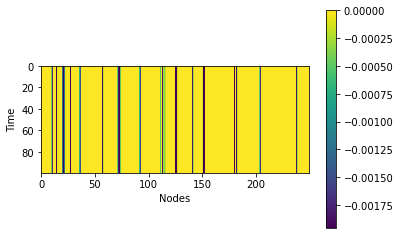

In [8]:
graph_idx = 0
tot_time = 100
u_soln = waveeqn_numerical_soln(graphs[graph_idx], Nt=tot_time)

plt.imshow(u_soln)
plt.colorbar()
plt.ylabel("Time")
plt.xlabel("Nodes")
plt.show()

### Grid and Ring Graphs

In [6]:
def adjacency_to_persdiag(A):
    sparse_A = sparse.csr_matrix(A)
    X_ggd = GraphGeodesicDistance(directed=False, unweighted=True, method="D").fit_transform([sparse_A])
    diagrams = VietorisRipsPersistence(metric="precomputed").fit_transform(X_ggd)
    return (X_ggd[0], diagrams[0])

In [7]:
# Create grid graph
Gone = nx.grid_2d_graph(4,4)
Aone = nx.to_numpy_array(Gone)
(GDone, dgm) = adjacency_to_persdiag(Aone)
H0_dgm_one, H1_dgm_one = get_multipicity(dgm)

In [8]:
# Go through each row in adjacency matrix and remove one connection randomly (don't want a singular matrix)
Atwo = nx.to_numpy_array(nx.grid_2d_graph(4,4))
for i in range(Atwo.shape[0]):
    connecind = np.argwhere(Atwo[i,:] == 1).squeeze()
    rmind = np.random.choice(connecind,size=1)
    Atwo[i,rmind] = 0
Gtwo = nx.from_numpy_matrix(Atwo)
(GDtwo, dgm) = adjacency_to_persdiag(Atwo)
H0_dgm_two, H1_dgm_two = get_multipicity(dgm)

# Create rings
n = 10
Athree = np.zeros((n,n))
for i in range(n):
    if i == n-1:
        Athree[i,0] = 1
        break
    Athree[i,i+1] = 1
Gthree = nx.from_numpy_matrix(Athree)
(GDthree, dgm) = adjacency_to_persdiag(Athree)
H0_dgm_three, H1_dgm_three = get_multipicity(dgm)

# Create ring with cord
n = 10
Afour = np.zeros((n,n))
for i in range(n):
    if i == n-1:
        Afour[i,0] = 1
        break
    Afour[i,i+1] = 1
Afour[5,0] = 1
Gfour = nx.from_numpy_matrix(Afour)
(GDfour, dgm) = adjacency_to_persdiag(Afour)
H0_dgm_four, H1_dgm_four = get_multipicity(dgm)

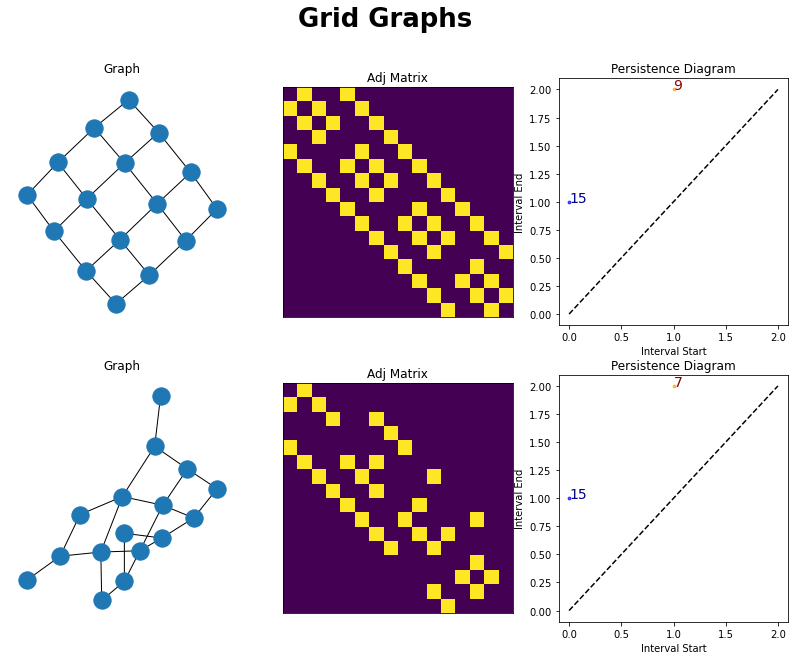

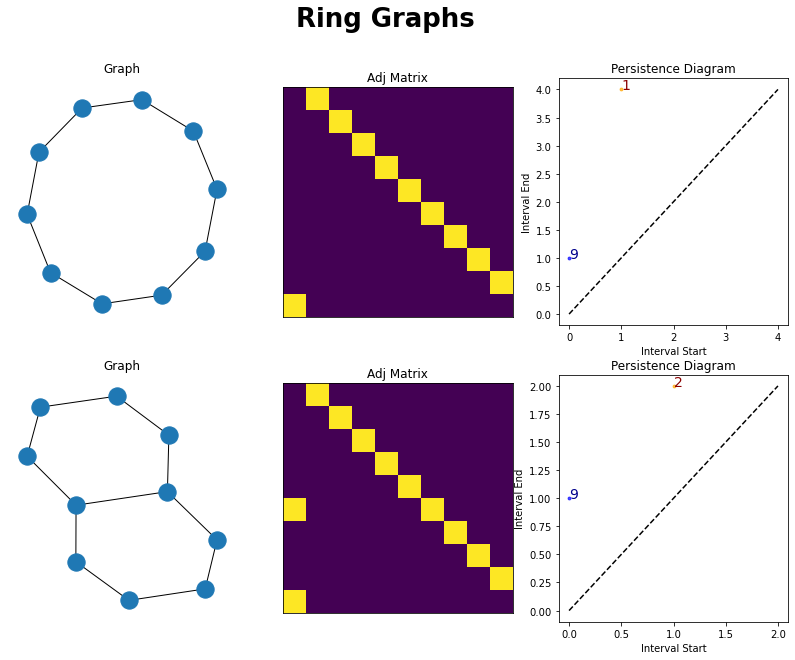

In [9]:
plt.figure(figsize=(14,10))
plt.suptitle("Grid Graphs",fontweight='bold',fontsize=26)
plt.subplot(231)
nx.draw(Gone)
plt.title("Graph")
plt.subplot(232)
plt.imshow(Aone)
plt.title("Adj Matrix")
plt.xticks([])
plt.yticks([])
plt.subplot(233)
plt_diag(plt.gca(), H0_dgm_one, H1_dgm_one)
plt.title("Persistence Diagram")
plt.subplot(234)
nx.draw(Gtwo)
plt.title("Graph")
plt.subplot(235)
plt.imshow(Atwo)
plt.title("Adj Matrix")
plt.xticks([])
plt.yticks([])
plt.subplot(236)
plt_diag(plt.gca(), H0_dgm_two, H1_dgm_two)
plt.title("Persistence Diagram")
plt.savefig('Grid_graphs.png')


plt.figure(figsize=(14,10))
plt.suptitle("Ring Graphs",fontweight='bold',fontsize=26)
plt.subplot(231)
nx.draw(Gthree)
plt.title("Graph")
plt.subplot(232)
plt.imshow(Athree)
plt.title("Adj Matrix")
plt.xticks([])
plt.yticks([])
plt.subplot(233)
plt_diag(plt.gca(), H0_dgm_three, H1_dgm_three)
plt.title("Persistence Diagram")
plt.subplot(234)
nx.draw(Gfour)
plt.title("Graph")
plt.subplot(235)
plt.imshow(Afour)
plt.title("Adj Matrix")
plt.xticks([])
plt.yticks([])
plt.subplot(236)
plt_diag(plt.gca(), H0_dgm_four, H1_dgm_four)
plt.title("Persistence Diagram")
plt.savefig('Ring_graphs.png')

#### Solve wave equation (analytically, eigenvectors of the graph laplacian)

In [10]:
def computewave(spatsol, eivals, c, t, initcond):

    modes = np.arange(spatsol.shape[0])                                 # Defining shape of eigenmodes
    allmodes = np.zeros((t.shape[0],spatsol.shape[0],spatsol.shape[0])) # Defining matrix of eigenmodes
    
    for n in modes:                  # compute time evolution of soulution for each mode
        
        if eivals[n] < 0:
            continue

        # Compute coefficient
        coeff = np.zeros(spatsol.shape[0])
        for i in range(spatsol.shape[0]):
            coeff[i] = np.sin(np.sqrt(eivals[n])*(i+1)) * initcond[i]
        timecoeff = np.sum(coeff)

        # Store all eigenmodes
        solmode = np.zeros((t.shape[0],spatsol.shape[0]))
        for i in range(len(t)):
            const = (2/((n+1)*np.pi*c))
            solmode[i,:] = const * timecoeff * np.cos(np.sqrt(eivals[n])*c*t[i]) * spatsol[:,n]
            
        allmodes[:,:,n] = solmode
        
    finalsol = np.sum(allmodes, axis=2)        # summing over all modes
    return finalsol, allmodes


def computeheat(spatsol, eivals, c, t, initcond):

    modes = np.arange(spatsol.shape[0])                                  # Defining shape of eigenmodes
    allmodes = np.zeros((t.shape[0],spatsol.shape[0],spatsol.shape[0]))  # Defining matrix of eigenmodes
    
    for n in modes:                  # compute time evolution of soulution for each mode
        
        if eivals[n] < 0:
            continue

        # Compute coefficient
        coeff = np.zeros(spatsol.shape[0])
        for i in range(spatsol.shape[0]):
            coeff[i] = np.sin(np.sqrt(eivals[n])*(i+1)) * initcond[i]
        timecoeff = np.sum(coeff)

        # Store all eigenmodes
        solmode = np.zeros((t.shape[0],spatsol.shape[0]))
        for i in range(len(t)):
            const = (2/((n+1)*np.pi*c))
            solmode[i,:] = const * timecoeff * np.exp(-np.sqrt(eivals[n])*c*t[i]) * spatsol[:,n]
            
        allmodes[:,:,n] = solmode
        
    finalsol = np.sum(allmodes, axis=2)        # summing over all modes
    return finalsol, allmodes

def get_degree(A):
    return np.diag(np.sum(A, axis=1))

def laplacian(D, A):
    return D - A

def waveeqn_eigenmodes(D, L):
    op = D @ L
    eigval, eigvec = np.linalg.eigh(L)
    eigval[0] = 0
    return (eigval, eigvec)

In [11]:
G_adj = [Aone, Atwo, Athree, Afour]
G_degree = [get_degree(A) for A in G_adj]
G_laplacian = [laplacian(D, A) for (D,A) in zip(G_degree,G_adj)]
G_degree_inv = [np.linalg.inv(A) for A in G_degree]
G_eigenmodes = [waveeqn_eigenmodes(D, L) for (D,L) in zip(G_degree,G_laplacian)]

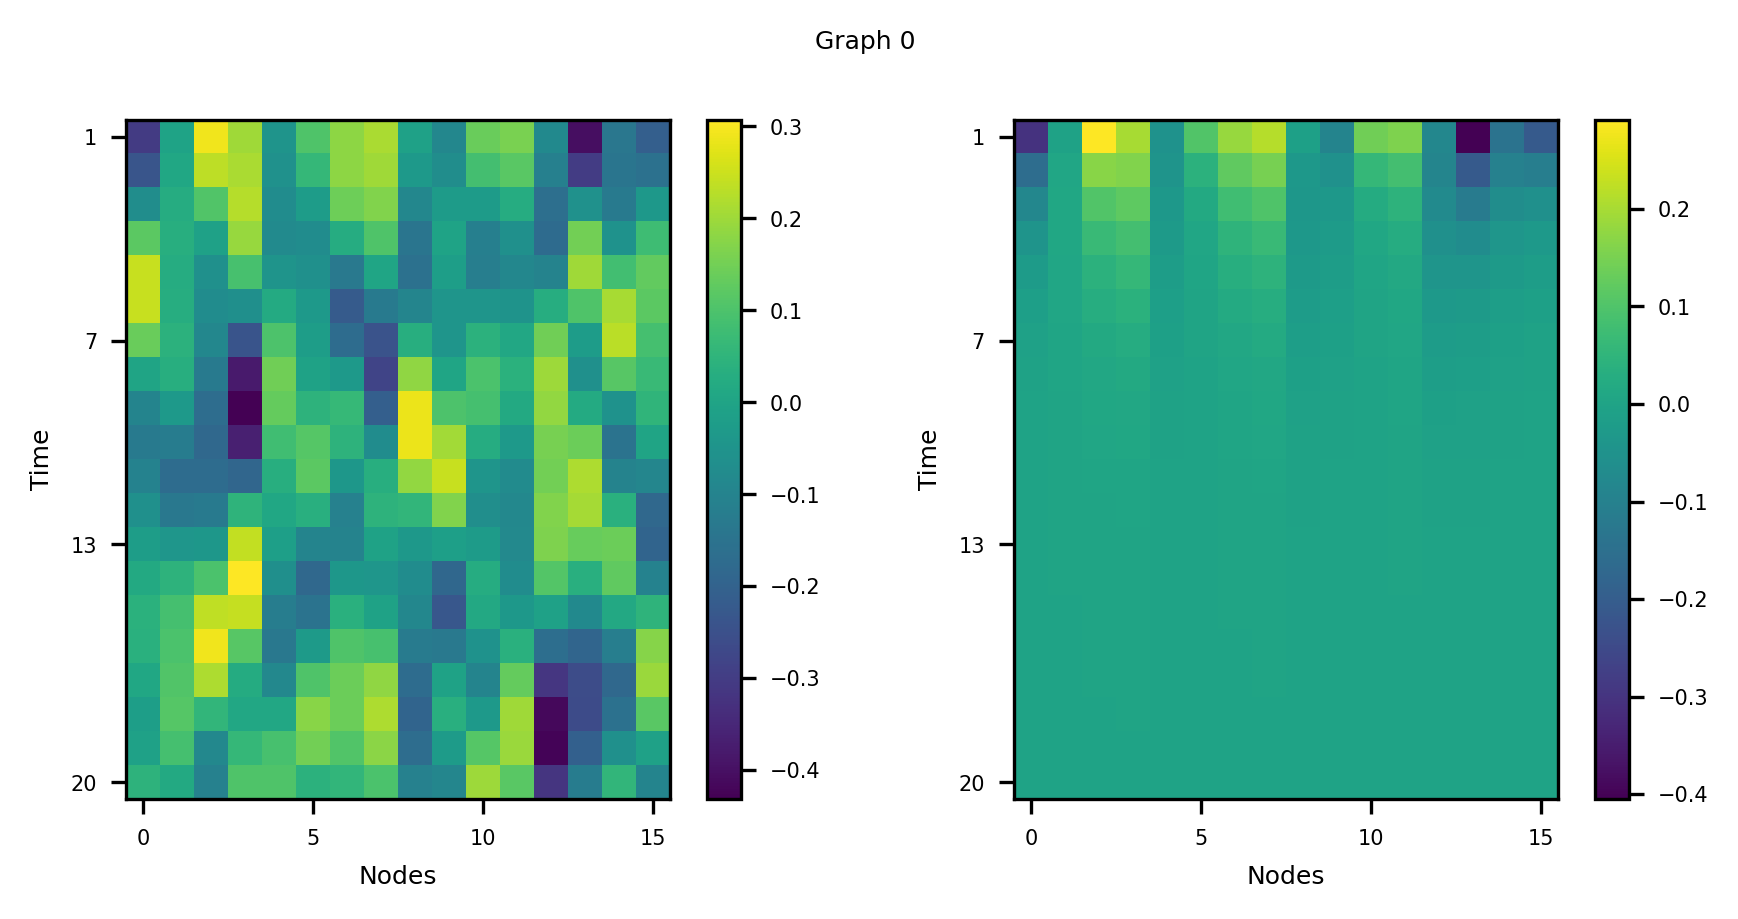

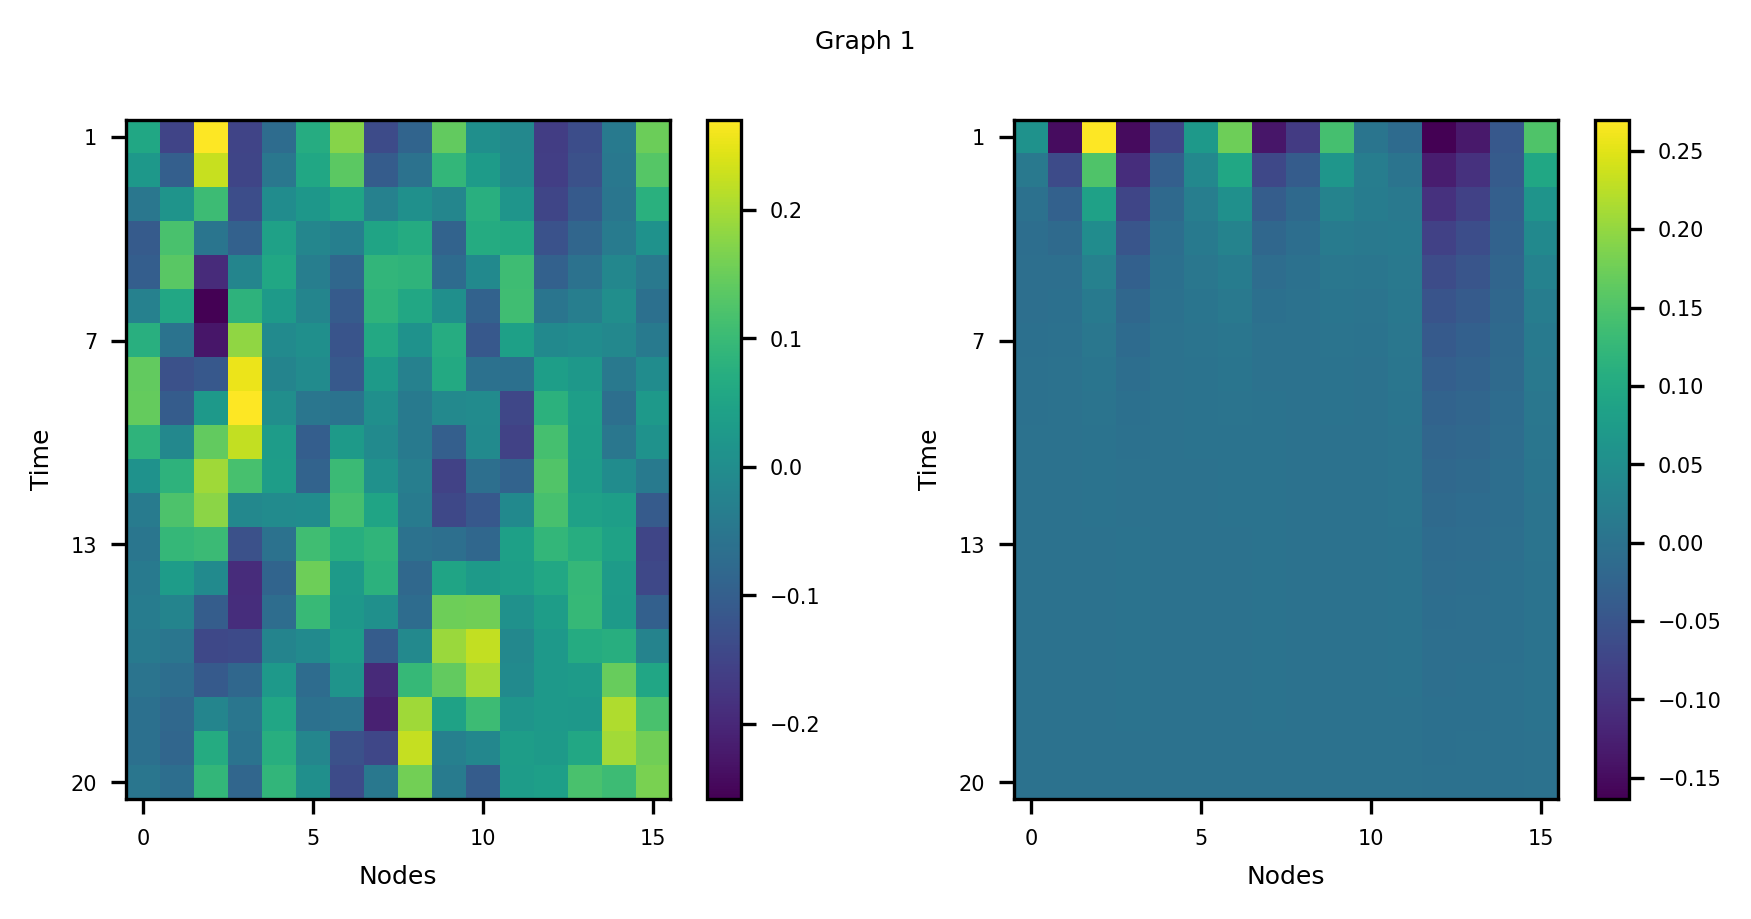

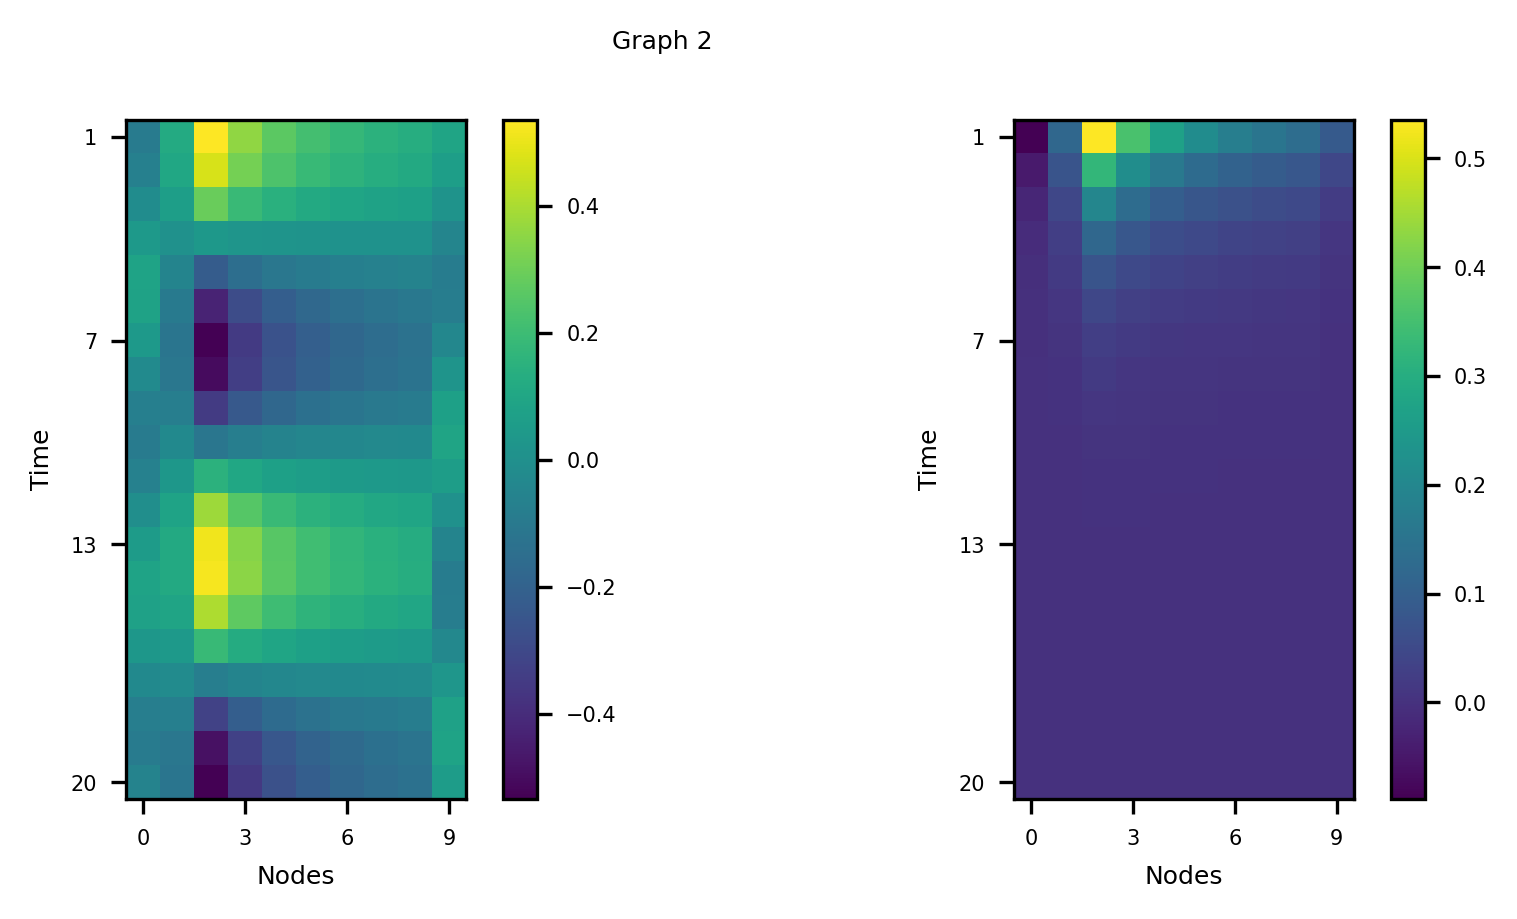

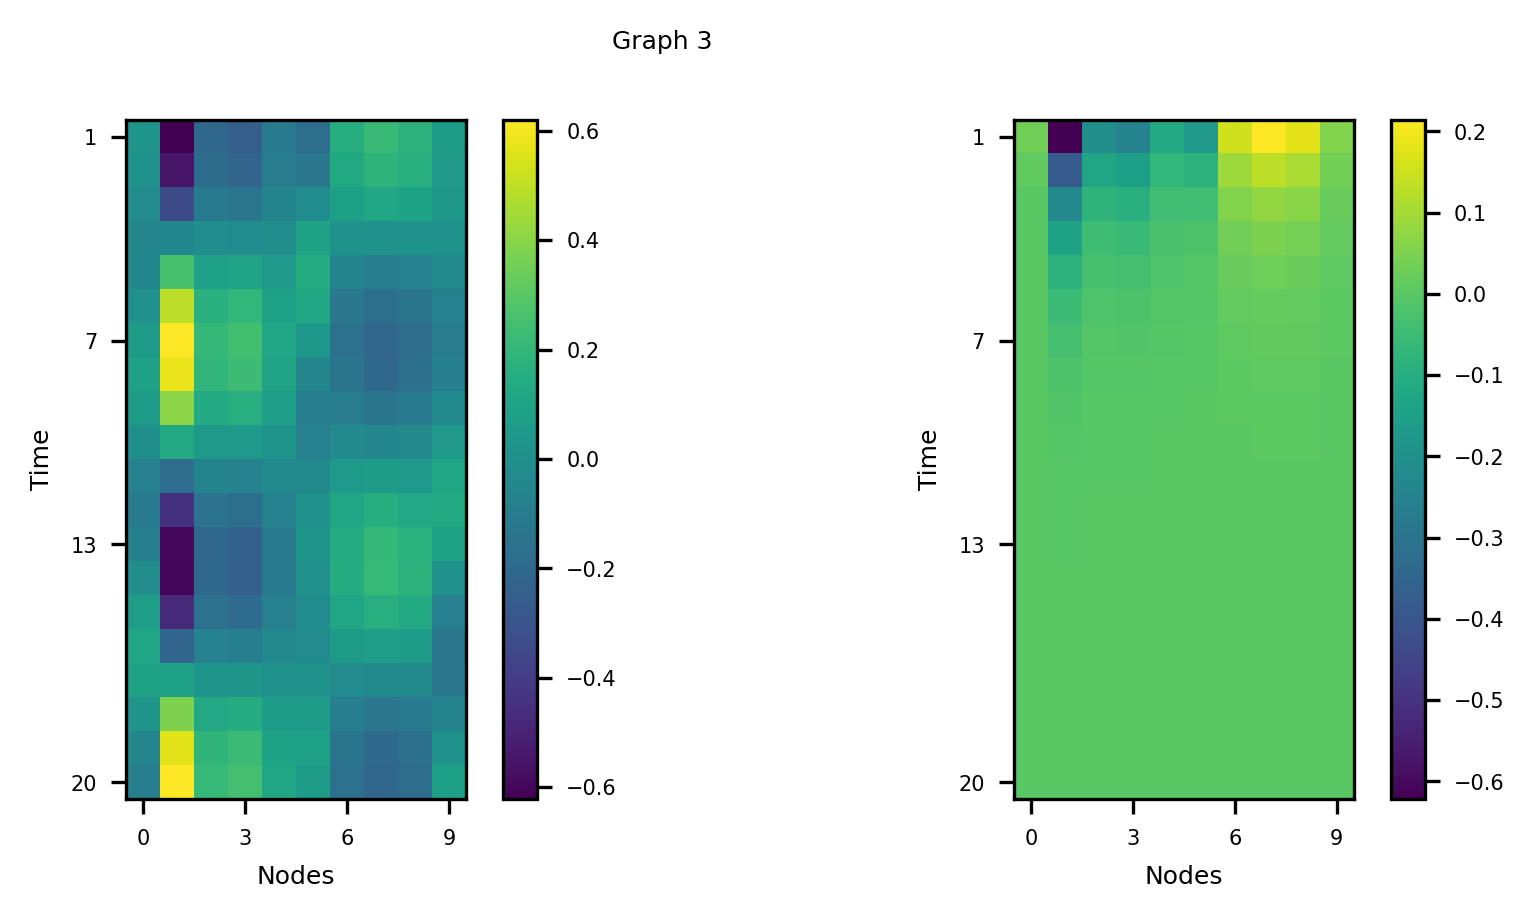

In [14]:
c = 0.5       # wave velocity
num_tp = 20   # num. time points

tp = np.arange(num_tp)   

for G_idx in range(len(G_adj)):
    
    num_nodes = G_eigenmodes[G_idx][1].shape[0]
    
    initial_condition = np.zeros(num_nodes)
    
    # randomly choose initial condition
    initial_condition[0] = 1
    
    # solve wave equation
    w_soln, w_modes = computewave(G_eigenmodes[G_idx][1], G_eigenmodes[G_idx][0], 
                                  c, tp, initial_condition)
    
    # solve heat equation
    h_soln, h_modes = computeheat(G_eigenmodes[G_idx][1], G_eigenmodes[G_idx][0], 
                                  c, tp, initial_condition)
    
    plt_xticks = np.linspace(0, num_nodes-1, 5)
    if num_nodes % 2 == 0:
        plt_xticks = np.linspace(0, num_nodes-1, 4)
    plt_xticks = [int(tk) for tk in plt_xticks]
    
    plt_yticks = np.linspace(0, num_tp-1, 5)
    if num_nodes % 2 == 0:
        plt_yticks = np.linspace(0, num_tp-1, 4)
    plt_yticks = [int(tk) for tk in plt_yticks]
    
    # plot solution
    plt.figure(figsize=(7,3), dpi=300)
    plt.suptitle(f"Graph {G_idx}", fontsize=6)
    
    plt.subplot(121)
    plt.imshow(w_soln)
    plt.ylabel("Time", fontsize=6)
    plt.xlabel("Nodes", fontsize=6)
    plt.xticks(plt_xticks, plt_xticks, fontsize=5)
    plt.yticks(plt_yticks, [tk+1 for tk in plt_yticks], fontsize=5)
    cbar = plt.colorbar()
    cbar.ax.tick_params(labelsize=5)
    
    plt.subplot(122)
    plt.imshow(h_soln)
    plt.ylabel("Time", fontsize=6)
    plt.xlabel("Nodes", fontsize=6)
    plt.xticks(plt_xticks, plt_xticks, fontsize=5)
    plt.yticks(plt_yticks, [tk+1 for tk in plt_yticks], fontsize=5)
    cbar = plt.colorbar()
    cbar.ax.tick_params(labelsize=5)
    
    plt.show()